<a href="https://colab.research.google.com/github/dagisky/ML_Porjects/blob/master/Covid19GoogleDs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate user for google drive

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#2.1 Get the file
downloaded = drive.CreateFile({'id':'1lqGTBPWQW-1w1O36ZZrpcwtBE0bMJ9s8'}) # replace the id with id of file you want to access
downloaded.GetContentFile('Global_Mobility_Report.csv') 

In [0]:
#2.1 Get the file2
downloaded2 = drive.CreateFile({'id':'14tvuDQqbA8MCHtRgZPOpxku_Z6Kyb5V0'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('us_states_covid19_daily.csv') 

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from datetime import date, timedelta
# from us_states import states
%matplotlib inline
# read daily COVID19 case report
covid19_df = pd.read_csv('us_states_covid19_daily.csv') # https://www.kaggle.com/sudalairajkumar/covid19-in-usa
# read community mobility dataset
mobility_df = pd.read_csv('Global_Mobility_Report.csv') # https://www.google.com/covid19/mobility/

covid19_df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200430,AK,355.0,18764.0,NaN,19.0,NaN,NaN,NaN,NaN,NaN,252.0,78605f774dcba587c8b24512354a3830ef3b5e4f,2020-04-30T20:00:00Z,9.0,NaN,19119.0,19119.0,19119.0,2,0.0,0.0,0.0,0.0,0.0
1,20200430,AL,7019.0,80177.0,NaN,NaN,978.0,NaN,335.0,NaN,195.0,NaN,47546b95299bd673c18e27d5284d7ba75b362464,2020-04-30T20:00:00Z,269.0,978.0,87196.0,87196.0,87196.0,1,24.0,33.0,6570.0,177.0,6747.0
2,20200430,AR,3255.0,45124.0,NaN,95.0,402.0,NaN,NaN,23.0,85.0,1305.0,8f880ed4454e1fc3bbeff4b0655314f8878cbe22,2020-04-30T20:00:00Z,61.0,402.0,48379.0,48379.0,48379.0,5,2.0,13.0,2867.0,63.0,2930.0
3,20200430,AS,0.0,3.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14c16072106c6d59a534dfcbd590ca14f42e4a7f,2020-04-30T20:00:00Z,0.0,NaN,20.0,3.0,3.0,60,0.0,0.0,0.0,0.0,0.0
4,20200430,AZ,7648.0,64138.0,NaN,755.0,1169.0,311.0,NaN,194.0,NaN,1499.0,eb3be7d08e6c0e46e5aa79eb92b2da29f2e6dc13,2020-04-30T20:00:00Z,320.0,1169.0,71786.0,71786.0,71786.0,4,16.0,38.0,2527.0,446.0,2973.0


In [0]:
# Covid_total contains the total values of covid19 cases 
covid19_total = covid19_df[['dateChecked','state','positive', 'negative','hospitalizedCurrently','hospitalizedCumulative', 'inIcuCurrently','inIcuCumulative','onVentilatorCurrently','onVentilatorCumulative','recovered']]
# Covid_df holds the daily increase of values
covid19_df = covid19_df[['dateChecked','state', 'deathIncrease', 'hospitalizedIncrease', 'negativeIncrease', 'positiveIncrease', 'totalTestResultsIncrease']]
# Here I have limited the analysis to the United States 
mobility_df = mobility_df[mobility_df.country_region == 'United States']

In [0]:
# here the codes of the states in the data is changed to the full name
states = {'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona', 'CA': 'California','CO': 'Colorado','CT': 'Connecticut',
        'DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam','HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho', 'IL': 'Illinois',
        'IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana','MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota',
        'MO': 'Missouri','MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina','ND': 'North Dakota',
        'NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey','NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma',
        'OR': 'Oregon','PA': 'Pennsylvania','PR': 'Puerto Rico','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee',
        'TX': 'Texas','UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin','WV': 'West Virginia','WY': 'Wyoming'}


# the function week_of_year2dater takes an int (week of the year) and returns the date range of that week 
def week_of_year2dater(year, week):
  d = date(year,1,1)
  dlt = timedelta(days = (week-1)*7)
  return d + dlt,  d + dlt + timedelta(days=6)


In [0]:
covid19_df = covid19_df.replace(states.keys(), states.values()) # replace the state code to full string
covid19_df['dateChecked'] = pd.to_datetime(covid19_df['dateChecked']) # change the dateChecked column to datetime format 
mobility_df['date'] = pd.to_datetime(mobility_df["date"]) # change the date column to datetime format 
covid19_df = covid19_df.rename(columns={"dateChecked": "date"}, errors="raise") # change the column name of dateChecked to date

In [89]:
covid19_df.head()

,date,state,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-04-30 20:00:00+00:00,Alaska,0.0,0.0,0.0,0.0,0.0
1,2020-04-30 20:00:00+00:00,Alabama,24.0,33.0,6570.0,177.0,6747.0
2,2020-04-30 20:00:00+00:00,Arkansas,2.0,13.0,2867.0,63.0,2930.0
3,2020-04-30 20:00:00+00:00,American Samoa,0.0,0.0,0.0,0.0,0.0
4,2020-04-30 20:00:00+00:00,Arizona,16.0,38.0,2527.0,446.0,2973.0


To further understand the transmission of the virus across different states, a graph showing the dates from early February to late April against positive cases. The graph plots for all the states. This makes it difficult to understand as there are plots to more than 50 states in a single graph. In addition, Since the graphs are plotted for each day, it makes it further difficult to understand the effects of the community mobility have on the transmission of the virus. 

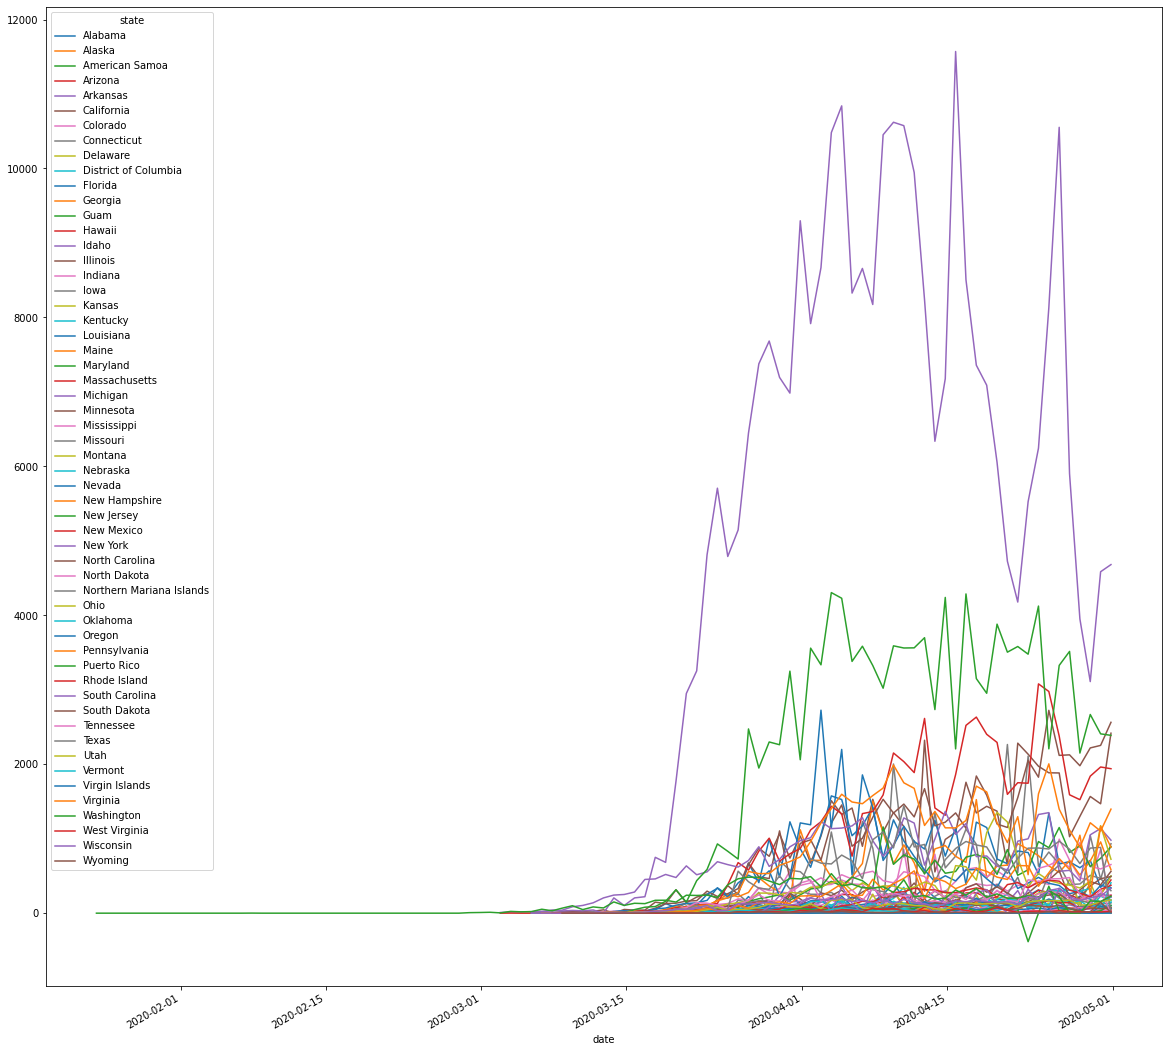

In [70]:
# plot the daily positive cases across all states
df = covid19_df.pivot(index='date', columns='state', values='positiveIncrease')
df.plot(figsize=(20,20))

In [0]:
def get_week_based_data(data):
  data['date'] = pd.to_datetime(data['date'])
  data['date'] = data['date'].dt.weekofyear
  data = data.groupby(['state', 'date']).mean().reset_index()
  weeks_str = list()
  for w in np.sort(data.date.unique()):
    s, e = week_of_year2dater(2020, int(w))
    weeks_str.append(str(s)+' - '+str(e))
  return data, weeks_str


In [0]:
covid19_week_data, weeks_str = get_week_based_data(covid19_df)

[Text(0, 0, '2020-01-22 - 2020-01-28'),
 Text(0, 0, '2020-01-29 - 2020-02-04'),
 Text(0, 0, '2020-02-05 - 2020-02-11'),
 Text(0, 0, '2020-02-12 - 2020-02-18'),
 Text(0, 0, '2020-02-19 - 2020-02-25'),
 Text(0, 0, '2020-02-26 - 2020-03-03'),
 Text(0, 0, '2020-03-04 - 2020-03-10'),
 Text(0, 0, '2020-03-11 - 2020-03-17'),
 Text(0, 0, '2020-03-18 - 2020-03-24'),
 Text(0, 0, '2020-03-25 - 2020-03-31')]

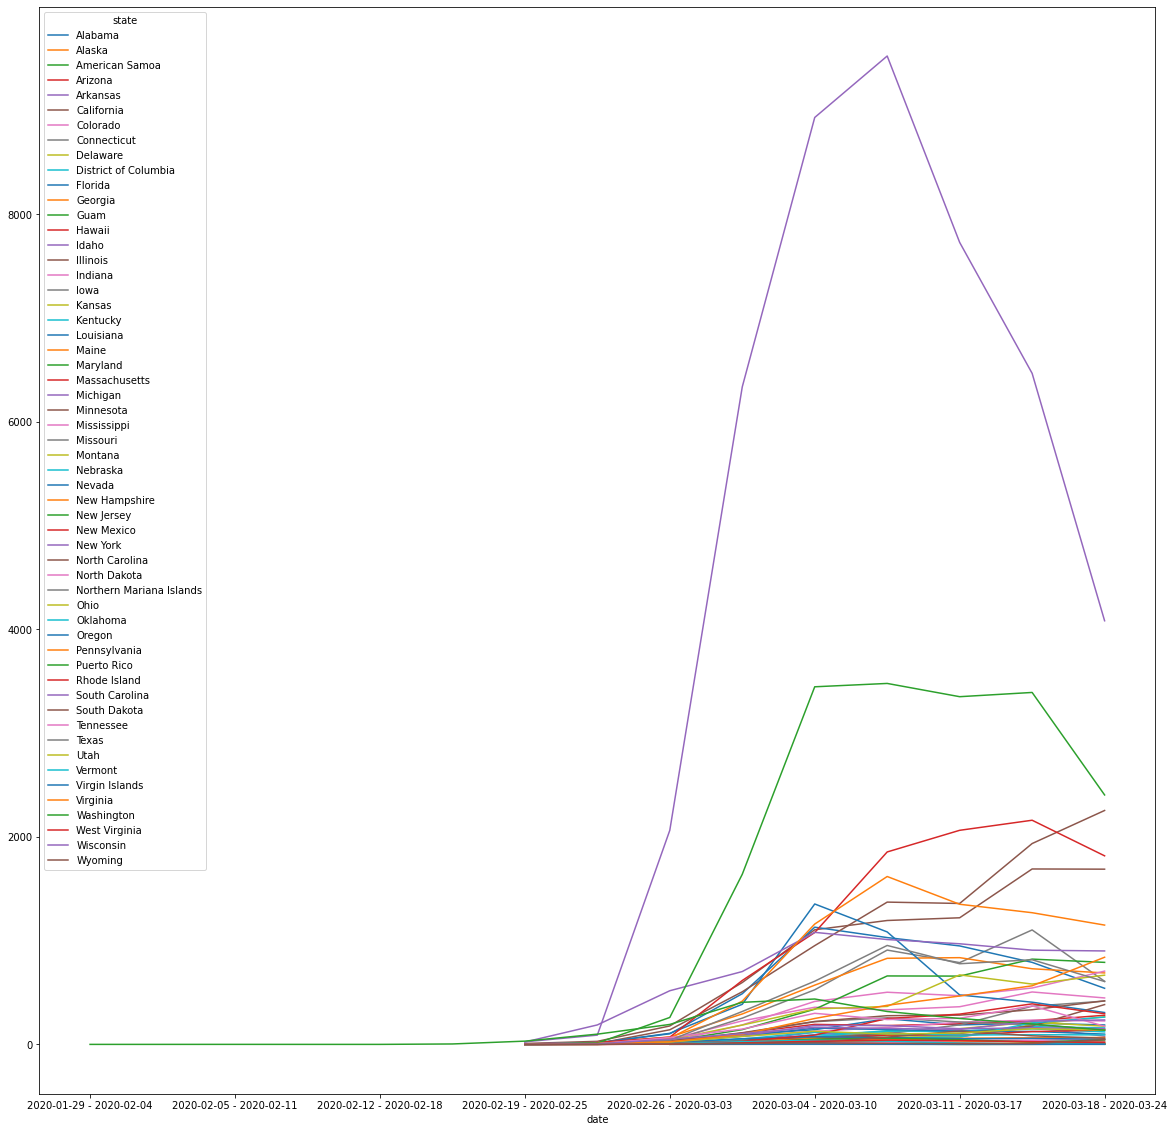

In [92]:
df = covid19_week_data.pivot(index='date', columns='state', values='positiveIncrease')
plt_prog = df.plot(figsize=(20,20))
plt_prog.set_xticklabels(weeks_str)

The figure above is crowded as we are trying to plot the number of confirmed cases across all the states in a single grph. Thus for visblity we devide the graph in to 10 states in a single graph.

/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the 

-----------------
['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia']
-----------------
['Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky']
-----------------
['Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska']
-----------------
['Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma']
-----------------
['Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont']


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


IndexError: ignored

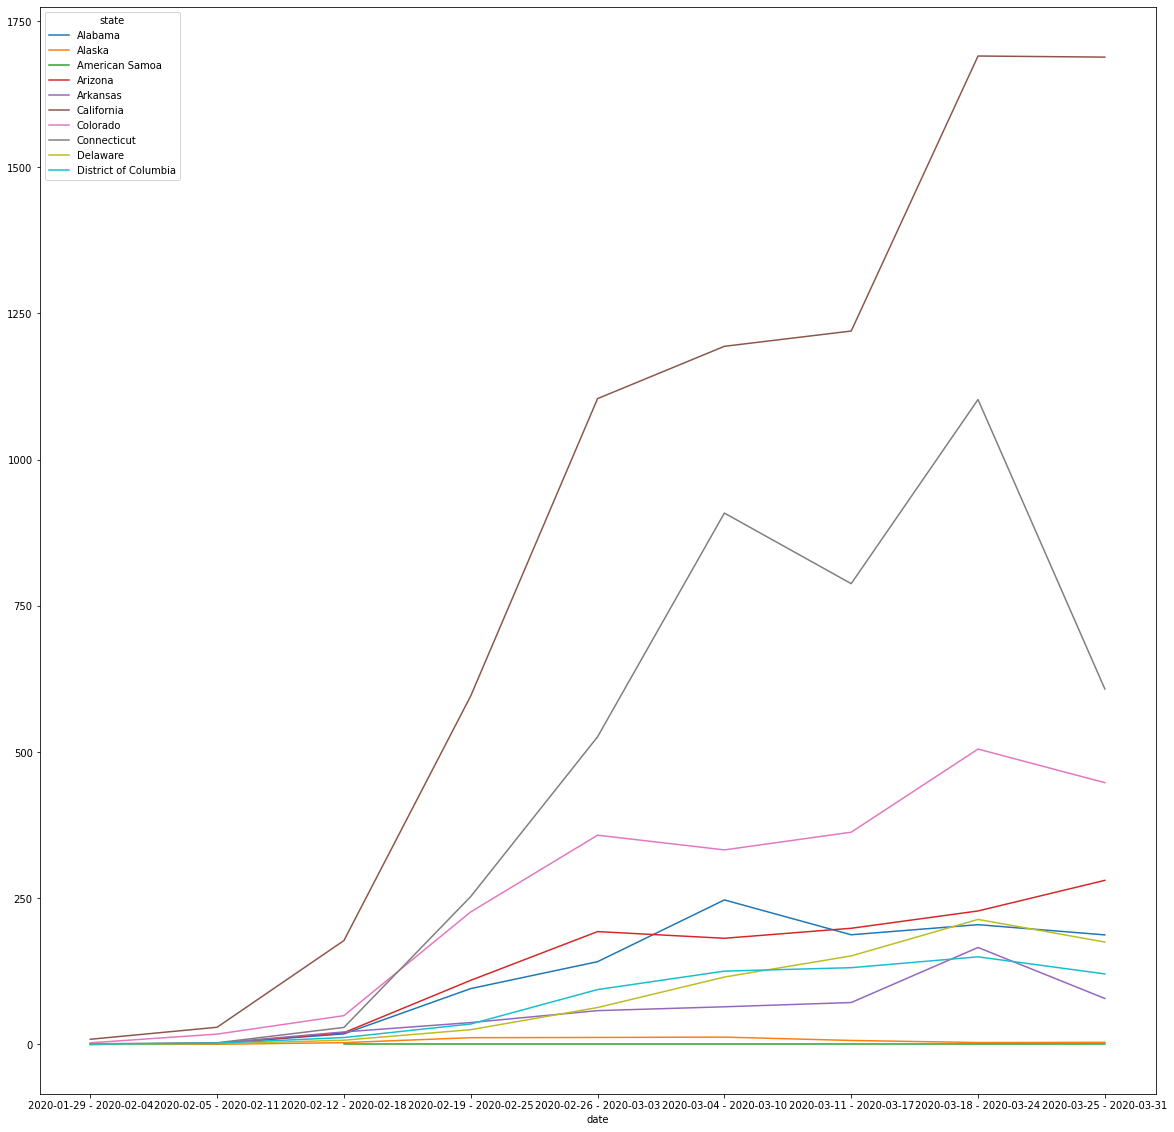

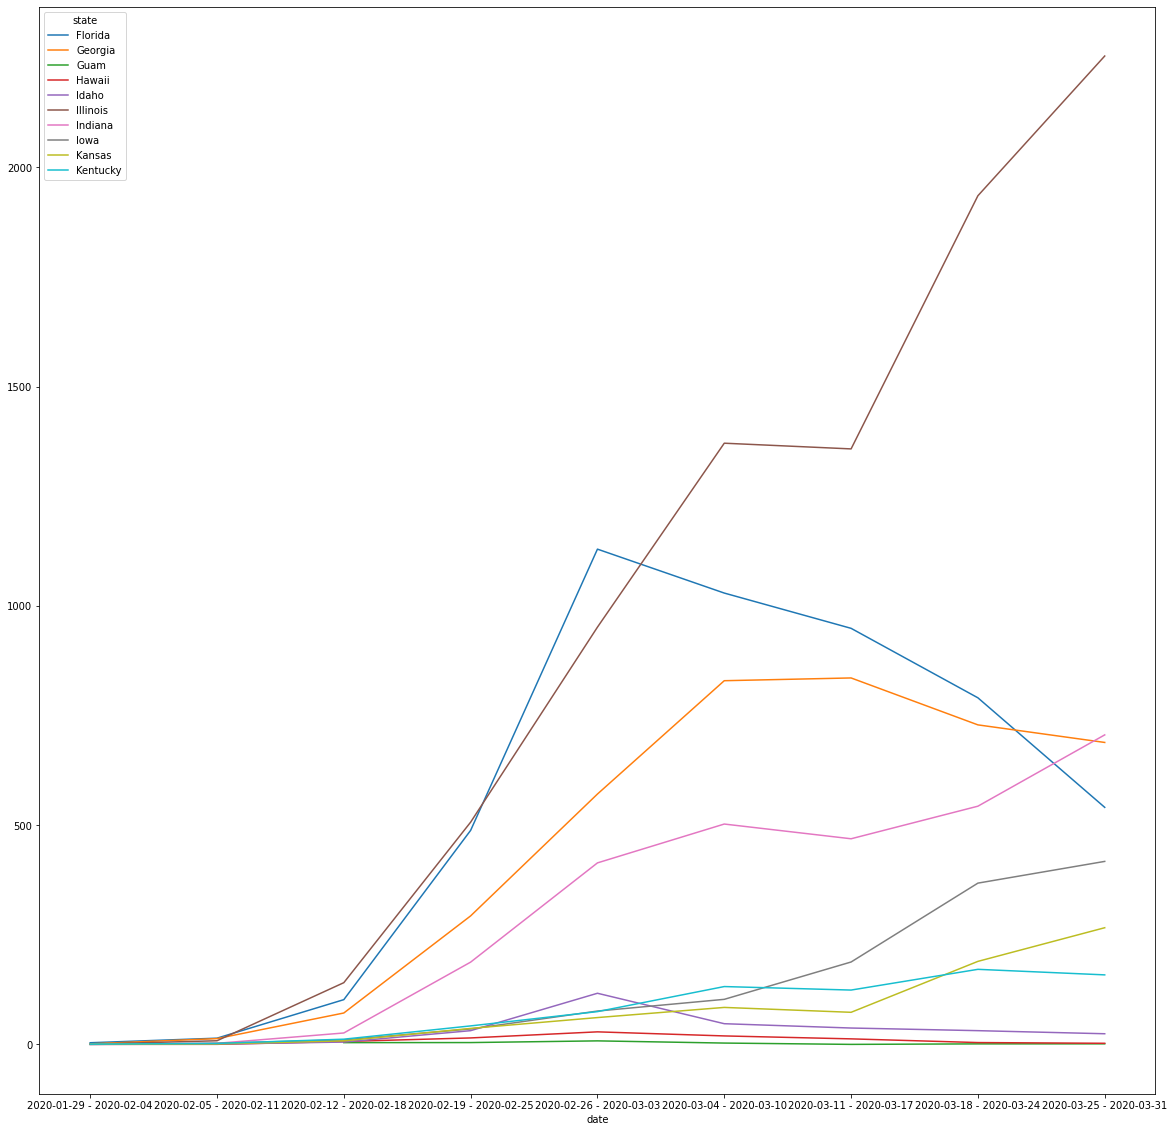

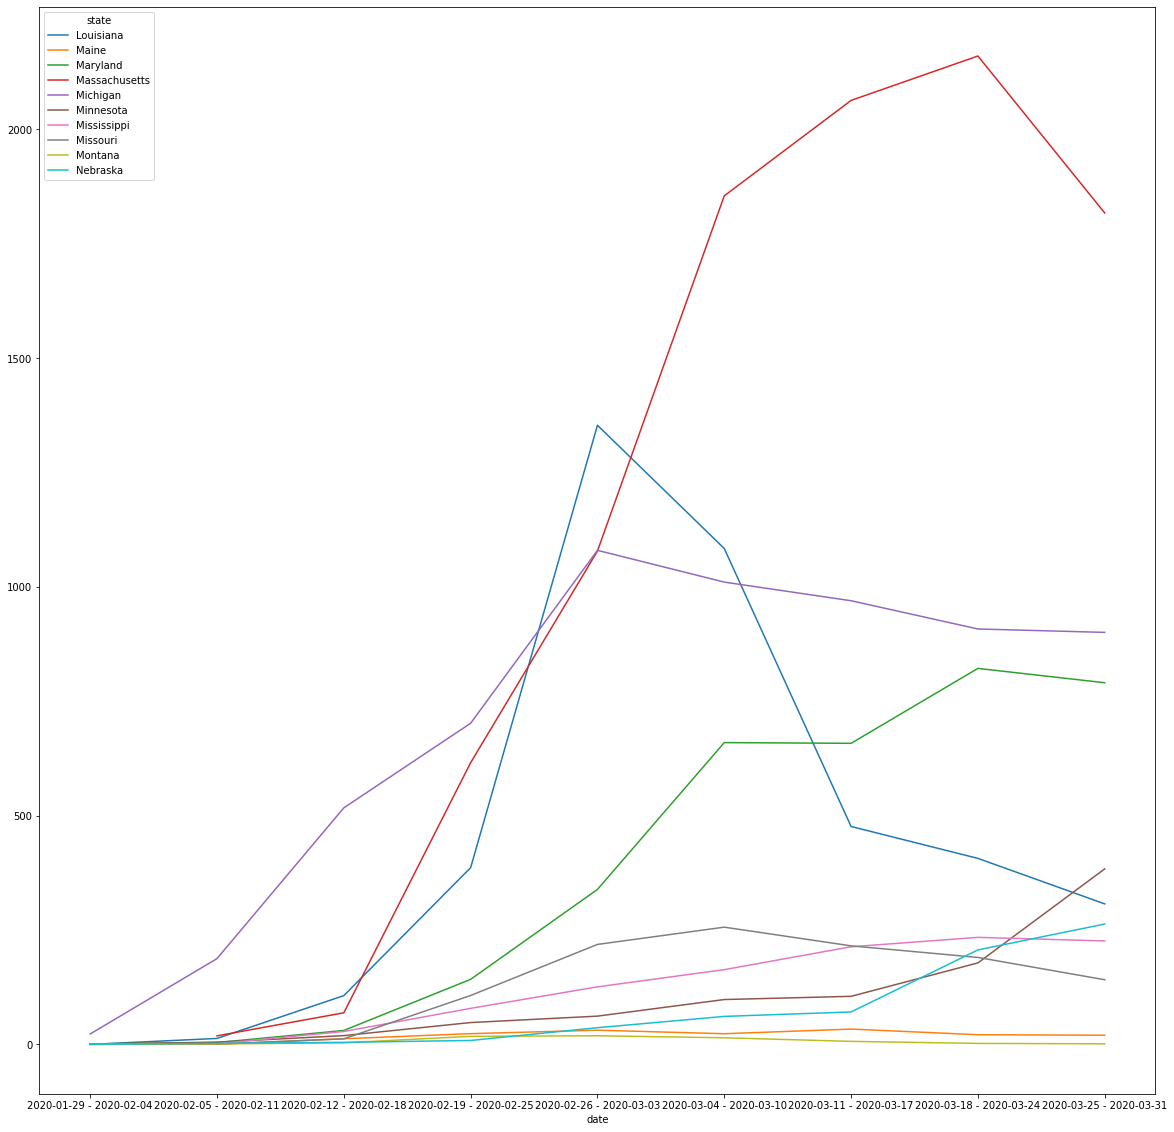

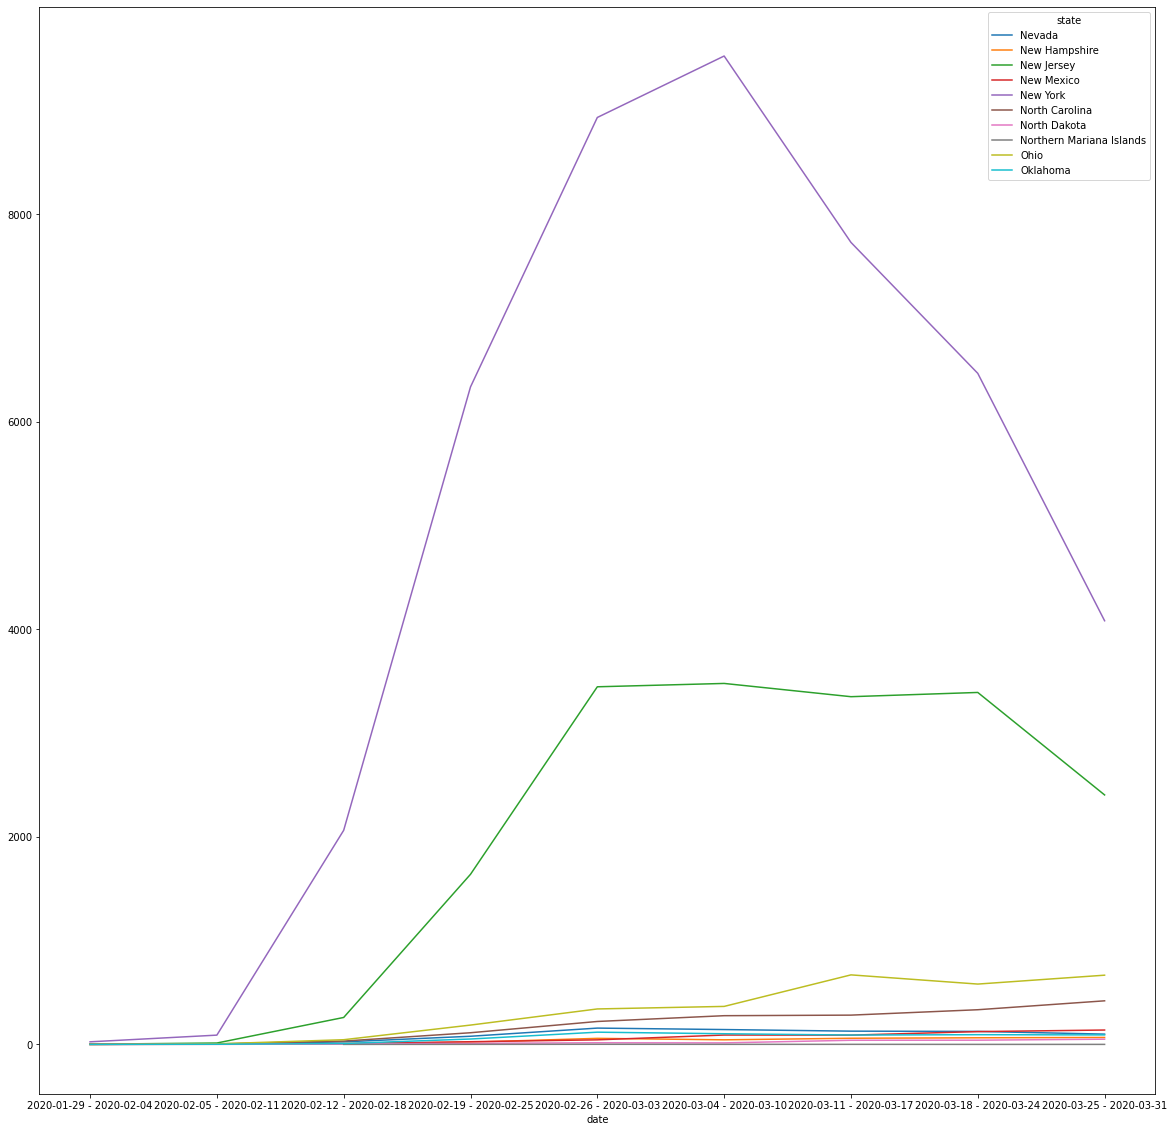

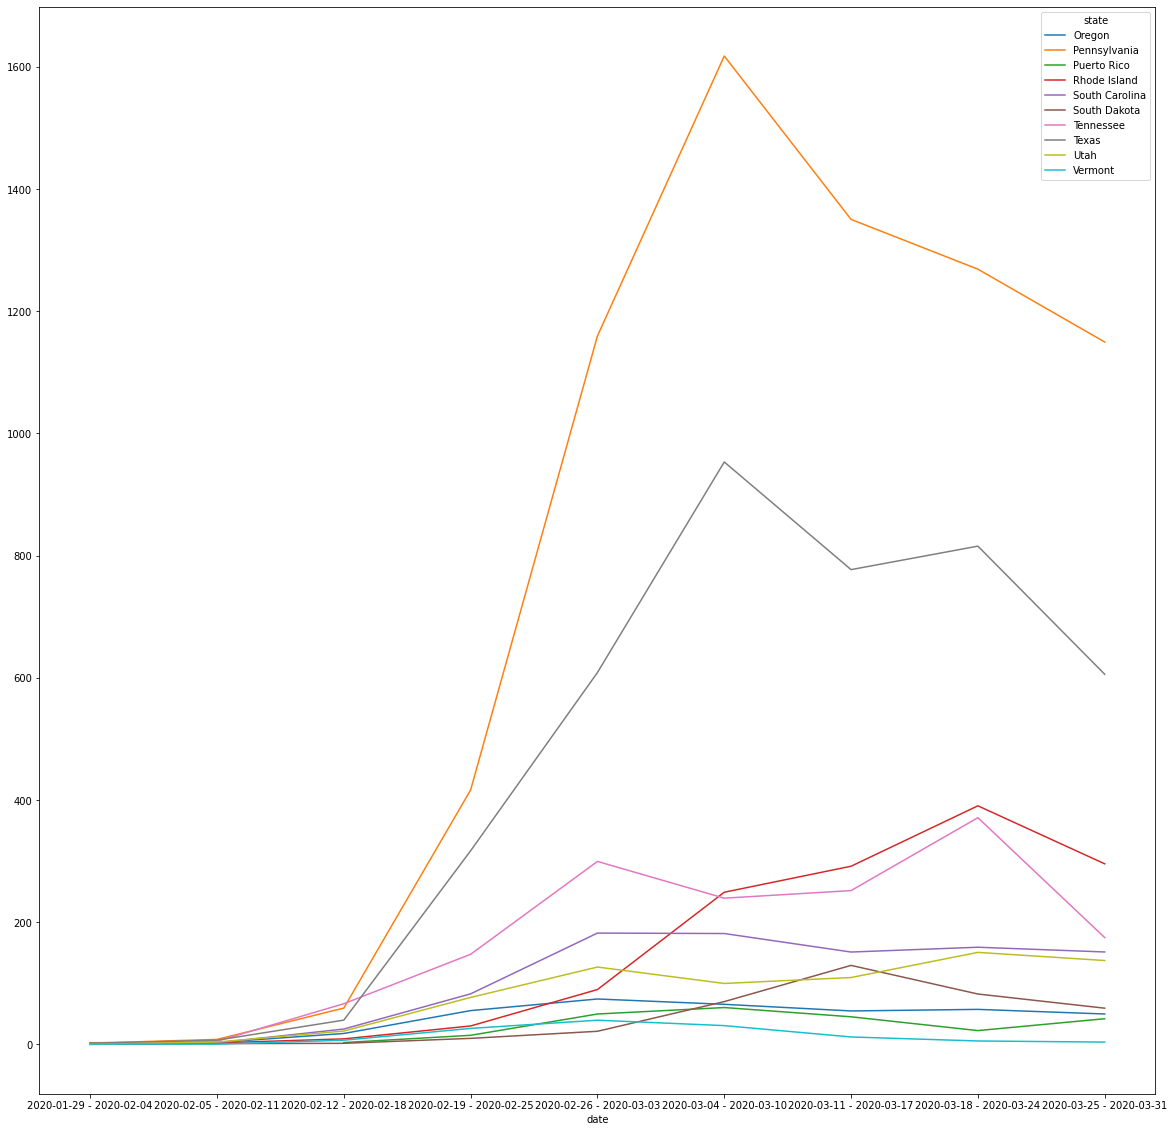

In [93]:
states_str = covid19_week_data.state.unique()
i = 0
while i < len(states_str):  
  state_q = (covid19_week_data.state==states_str[i]) + (covid19_week_data.state==states_str[i+1]) + (covid19_week_data.state==states_str[i+2])+ (covid19_week_data.state==states_str[i+3])+ (covid19_week_data.state==states_str[i+4])+ (covid19_week_data.state==states_str[i+5])+(covid19_week_data.state==states_str[i+6]) + (covid19_week_data.state==states_str[i+7]) + (covid19_week_data.state==states_str[i+8])+ (covid19_week_data.state==states_str[i+9])
  df = covid19_week_data[state_q].pivot(index='date', columns='state', values='positiveIncrease')
  print('-----------------')
  print([states_str[i], states_str[i+1], states_str[i+2],states_str[i+3],states_str[i+4],states_str[i+5],states_str[i+6],states_str[i+7],states_str[i+8],states_str[i+9]])
  plt_prog = df.plot(figsize=(20,20)) # figsize=(20,20)
  plt_prog.set_xticklabels(weeks_str)
  i += 10

The above graphs show the mean daily increase of confirmed cases across time calculated weekly. Now we observe the over all latest confirmed cases across the united states.

In [0]:
covid19_total = covid19_total.replace(states.keys(), states.values())
covid19_total['dateChecked'] = pd.to_datetime(covid19_total['dateChecked'])
covid19_total = covid19_total.rename(columns={"dateChecked": "date"}, errors="raise")

In [95]:
covid19_total.head()

,date,state,positive,negative,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered
0,2020-04-30 20:00:00+00:00,Alaska,355.0,18764.0,19.0,NaN,NaN,NaN,NaN,NaN,252.0
1,2020-04-30 20:00:00+00:00,Alabama,7019.0,80177.0,NaN,978.0,NaN,335.0,NaN,195.0,NaN
2,2020-04-30 20:00:00+00:00,Arkansas,3255.0,45124.0,95.0,402.0,NaN,NaN,23.0,85.0,1305.0
3,2020-04-30 20:00:00+00:00,American Samoa,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-30 20:00:00+00:00,Arizona,7648.0,64138.0,755.0,1169.0,311.0,NaN,194.0,NaN,1499.0


In [77]:
date = covid19_total.groupby(['state'])['date'].max()[0]
last_day = covid19_total[covid19_total.date == date]
last_day = last_day.dropna(axis=1)
last_day.head()

,date,state,positive,negative
0,2020-04-30 20:00:00+00:00,Alaska,355.0,18764.0
1,2020-04-30 20:00:00+00:00,Alabama,7019.0,80177.0
2,2020-04-30 20:00:00+00:00,Arkansas,3255.0,45124.0
3,2020-04-30 20:00:00+00:00,American Samoa,0.0,3.0
4,2020-04-30 20:00:00+00:00,Arizona,7648.0,64138.0


Text(0.5, 1.0, 'Covid19 across states of the US')

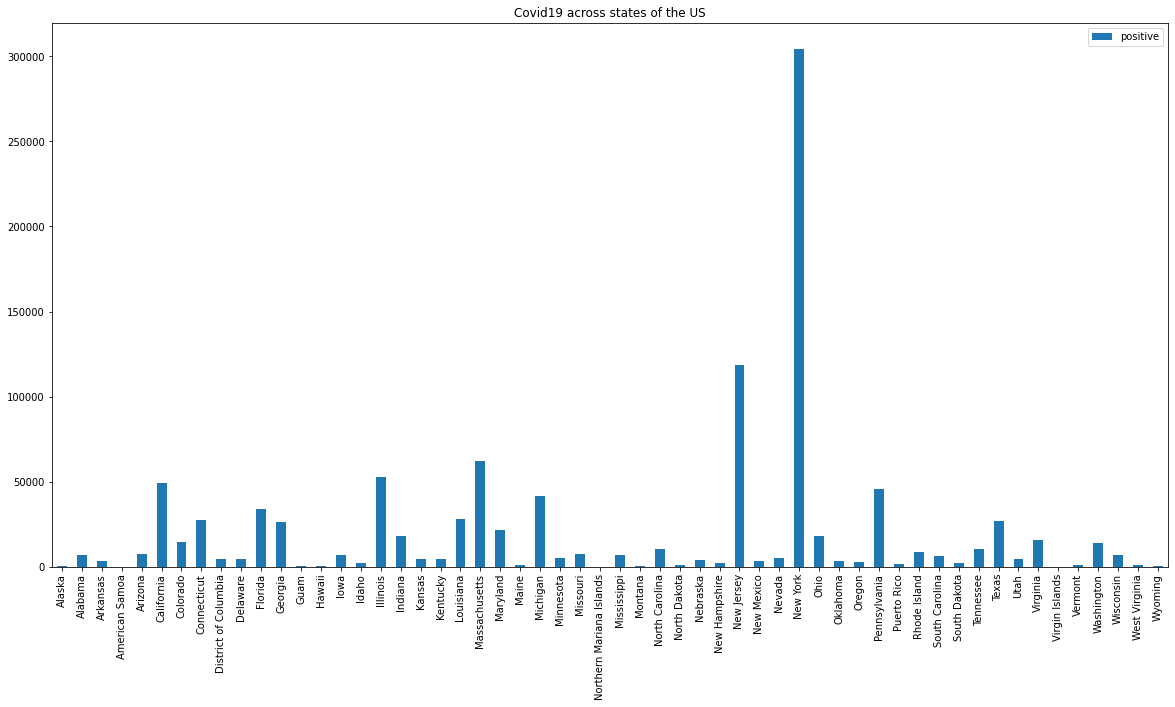

In [96]:
plot_data = last_day['positive'].to_frame()
# plot_data = plot_data.set_index(list(last_day['state']))
plot_1 = plot_data.plot(kind="bar", figsize=(20,10))
plot_1.set_xticklabels(list(last_day['state']))
plt.title("Covid19 across states of the US")

on the following section we take close look at the mean mobility of people across all states to different places

In [0]:
mobility_df = mobility_df.replace(states.keys(), states.values())

In [0]:
mobility_df = mobility_df[['sub_region_1', 'sub_region_2','date', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']]
mobility_df = mobility_df.rename(columns={"sub_region_1": "state"}, errors="raise") # change the column name of sub_region_1 to state
# mobility_df = mobility_df.rename(columns={"sub_region_2": "region"}, errors="raise") # change the column name of sub_region_1 to state

In [0]:
mobility_df = mobility_df.groupby(['state', 'date']).mean().reset_index()
mobility_df = mobility_df.dropna(subset=['state'], axis=0)

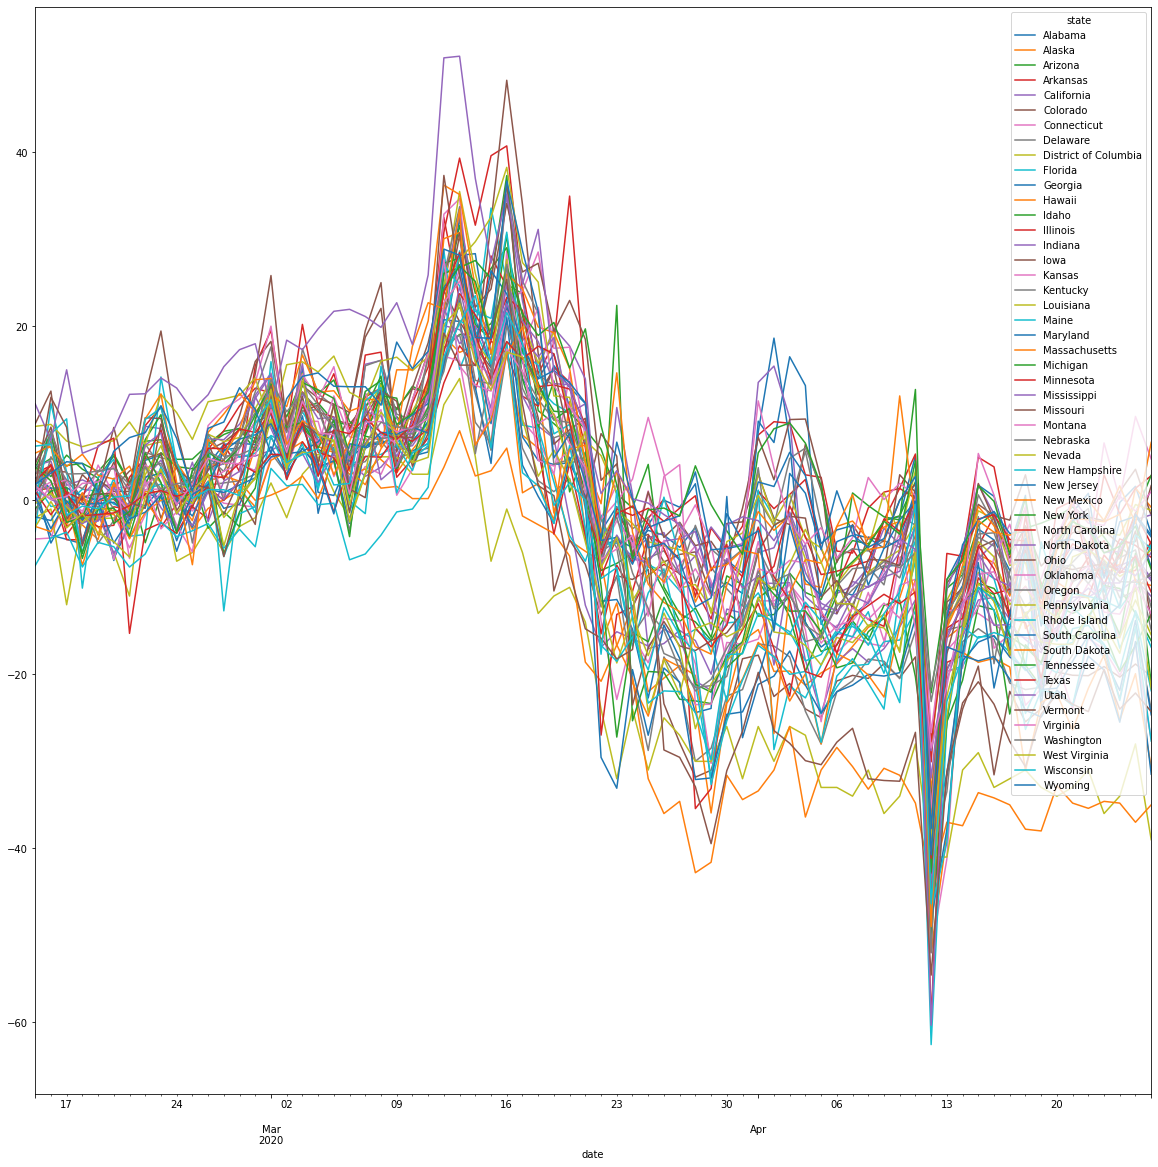

In [100]:
mobility_week_data = mobility_df
mobility_week_data['date'] = pd.to_datetime(mobility_week_data['date'])
df = mobility_week_data.pivot(index='date', columns='state', values='grocery_and_pharmacy_percent_change_from_baseline')
df.plot(figsize=(20,20))

In the following section shows the change in percentage from the baseline for people that visit grocery & pharmacy, parks, retailing centers, transit and stations and other places is plotted agenest date

In [0]:
locations = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']
def mobility_plot_us(mobility_data, destinations):
  for loc in destinations:
    mobility_week_data = mobility_data
    mobility_week_data['date'] = pd.to_datetime(mobility_week_data['date'])
    mobility_week_data = mobility_week_data.groupby(['date']).mean().reset_index()
    plt_prog = mobility_week_data.plot(x ='date', y=loc, kind = 'line', figsize=(20,20))

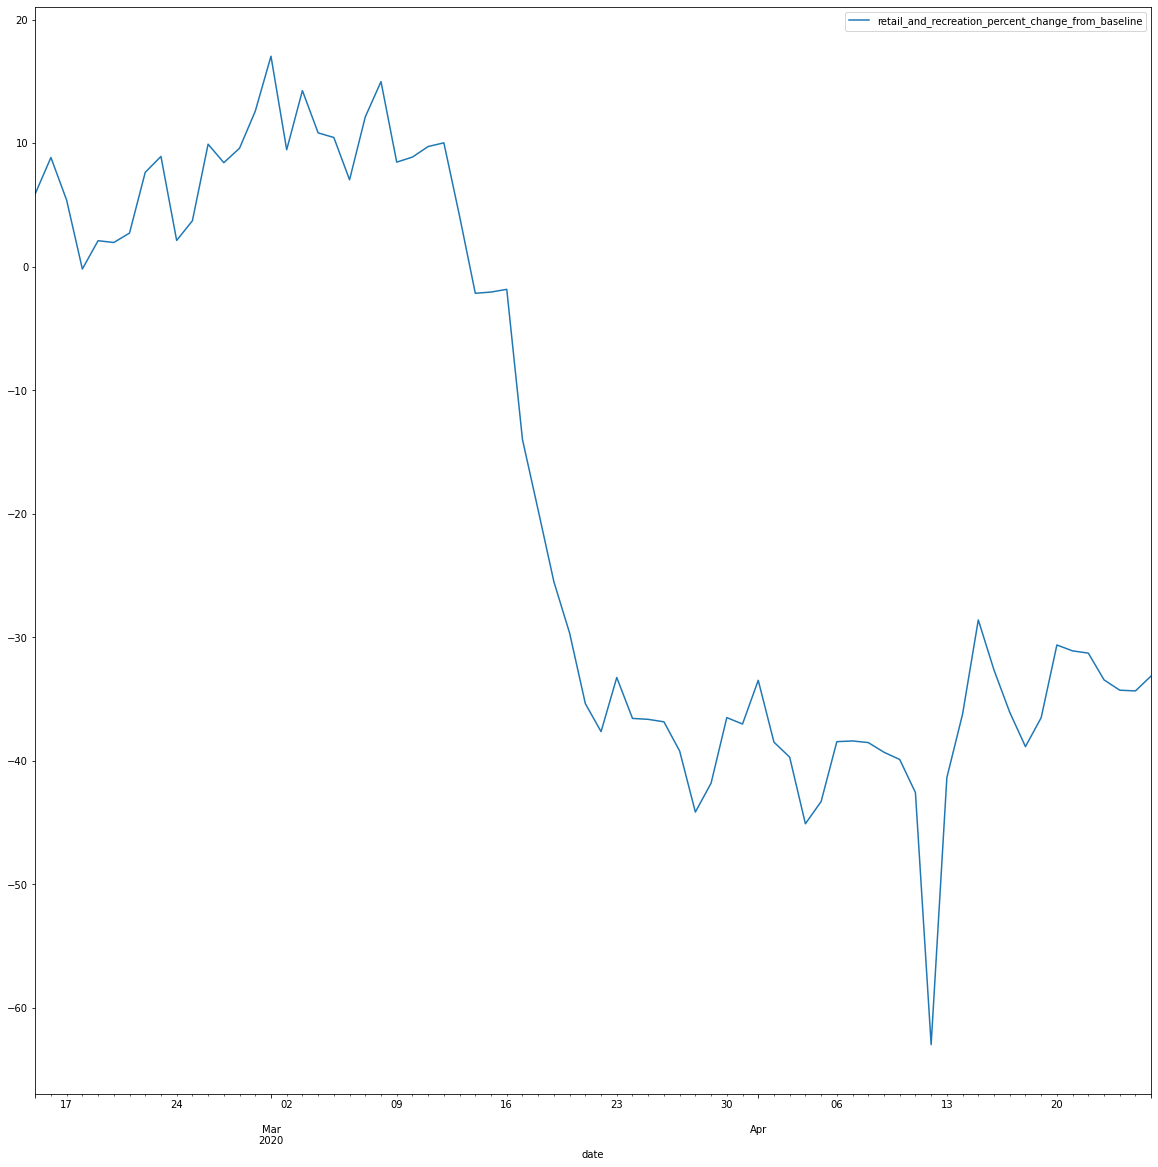

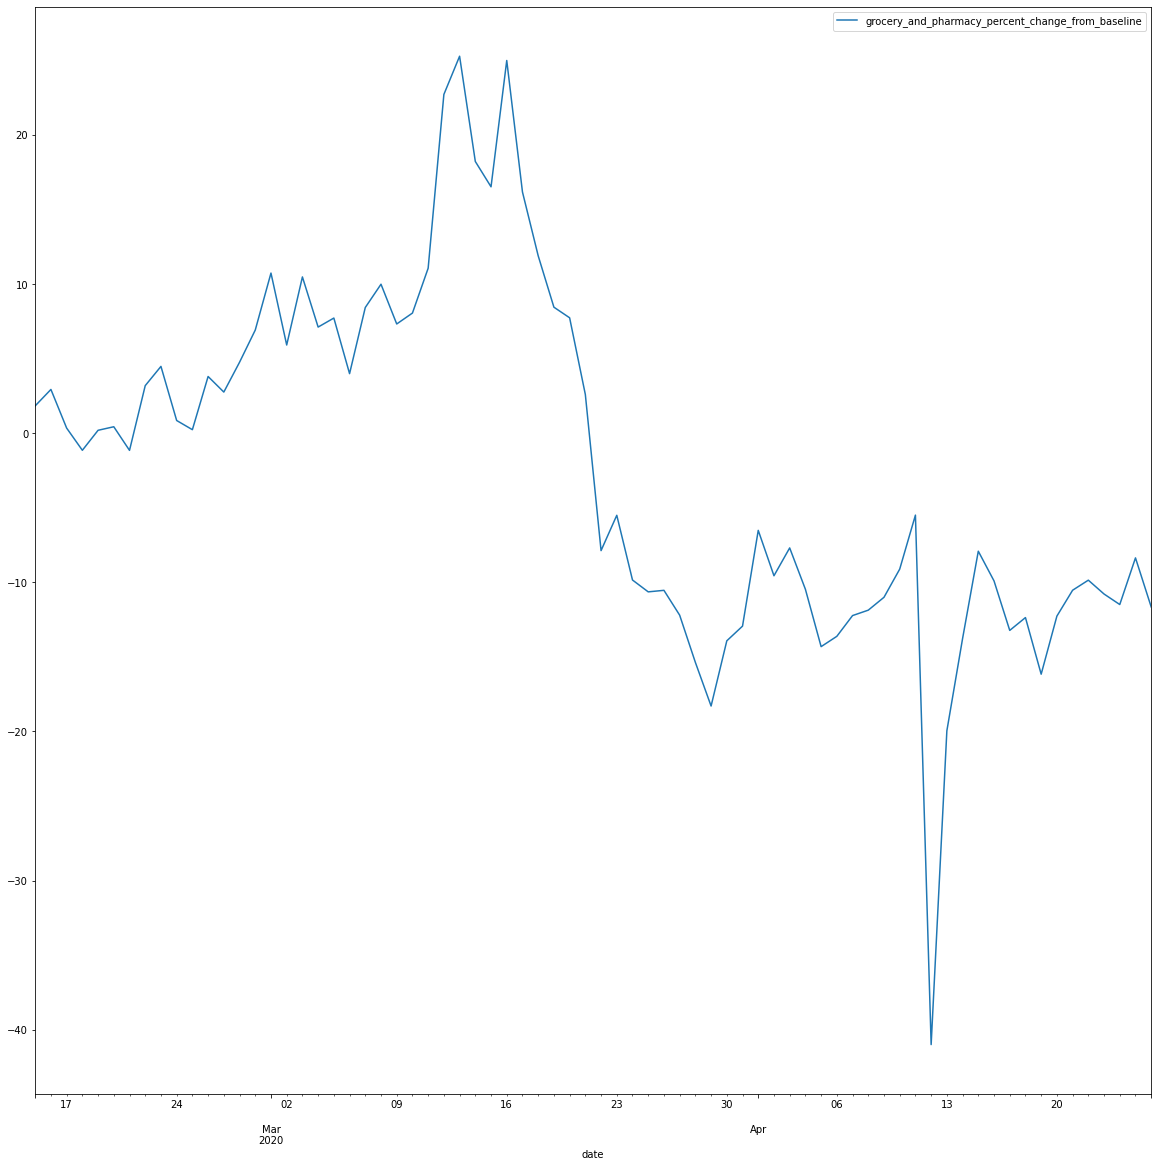

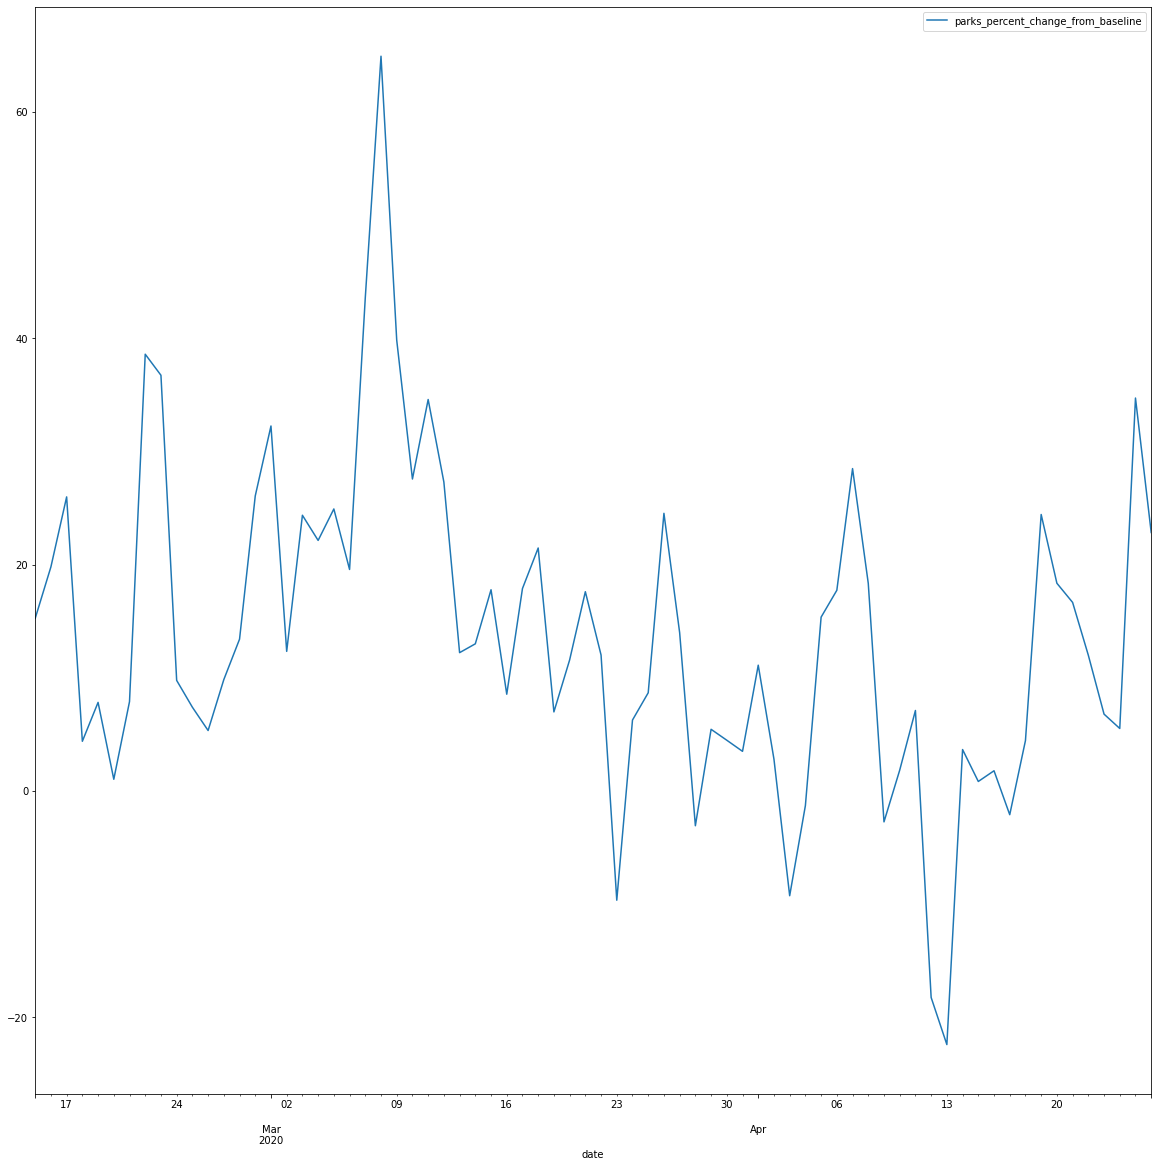

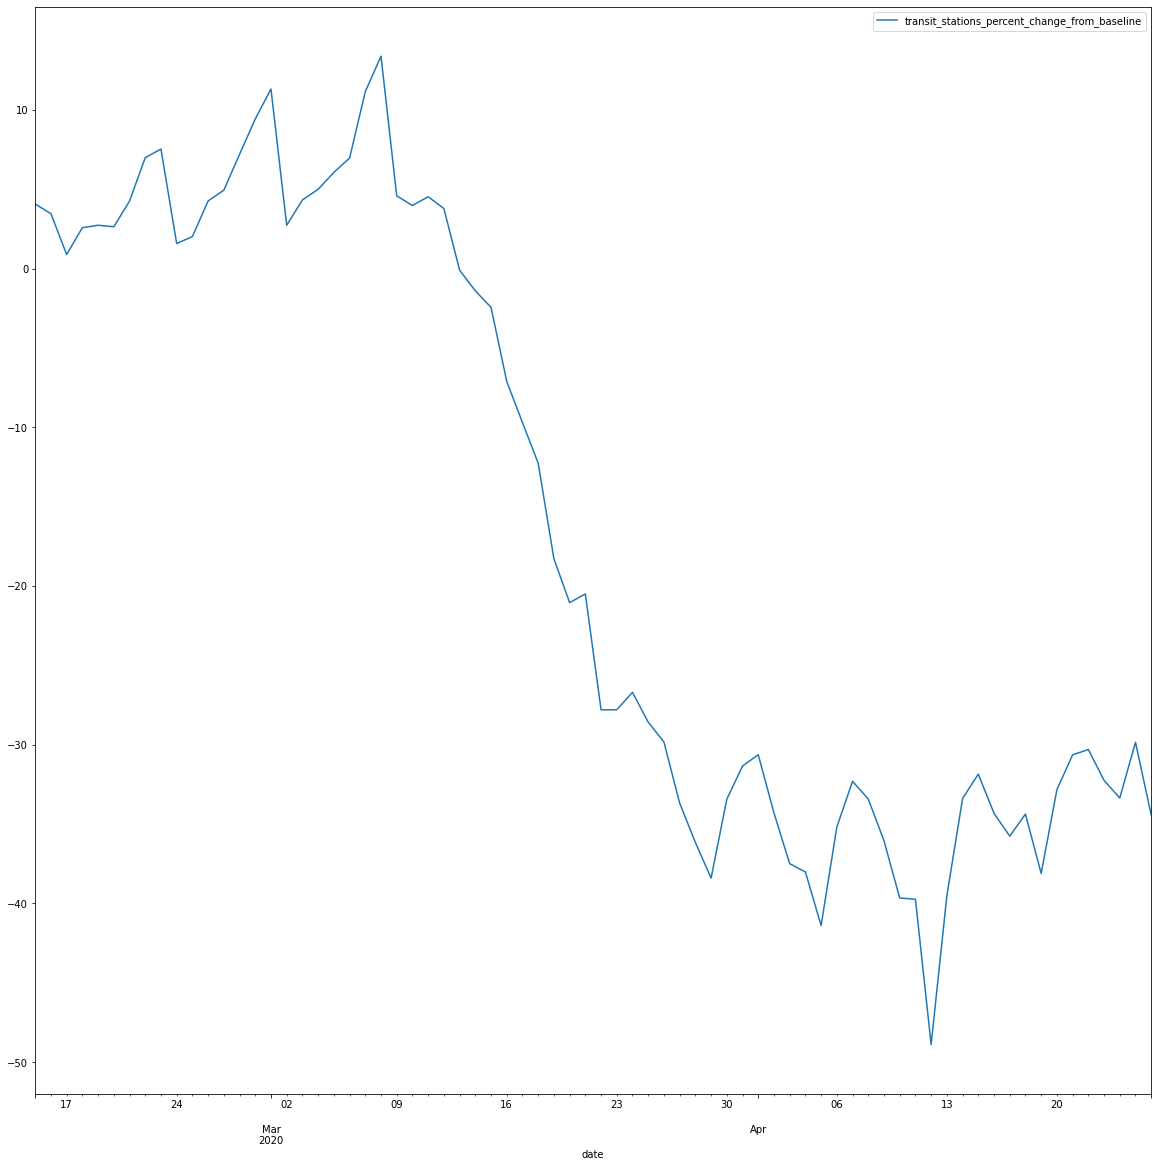

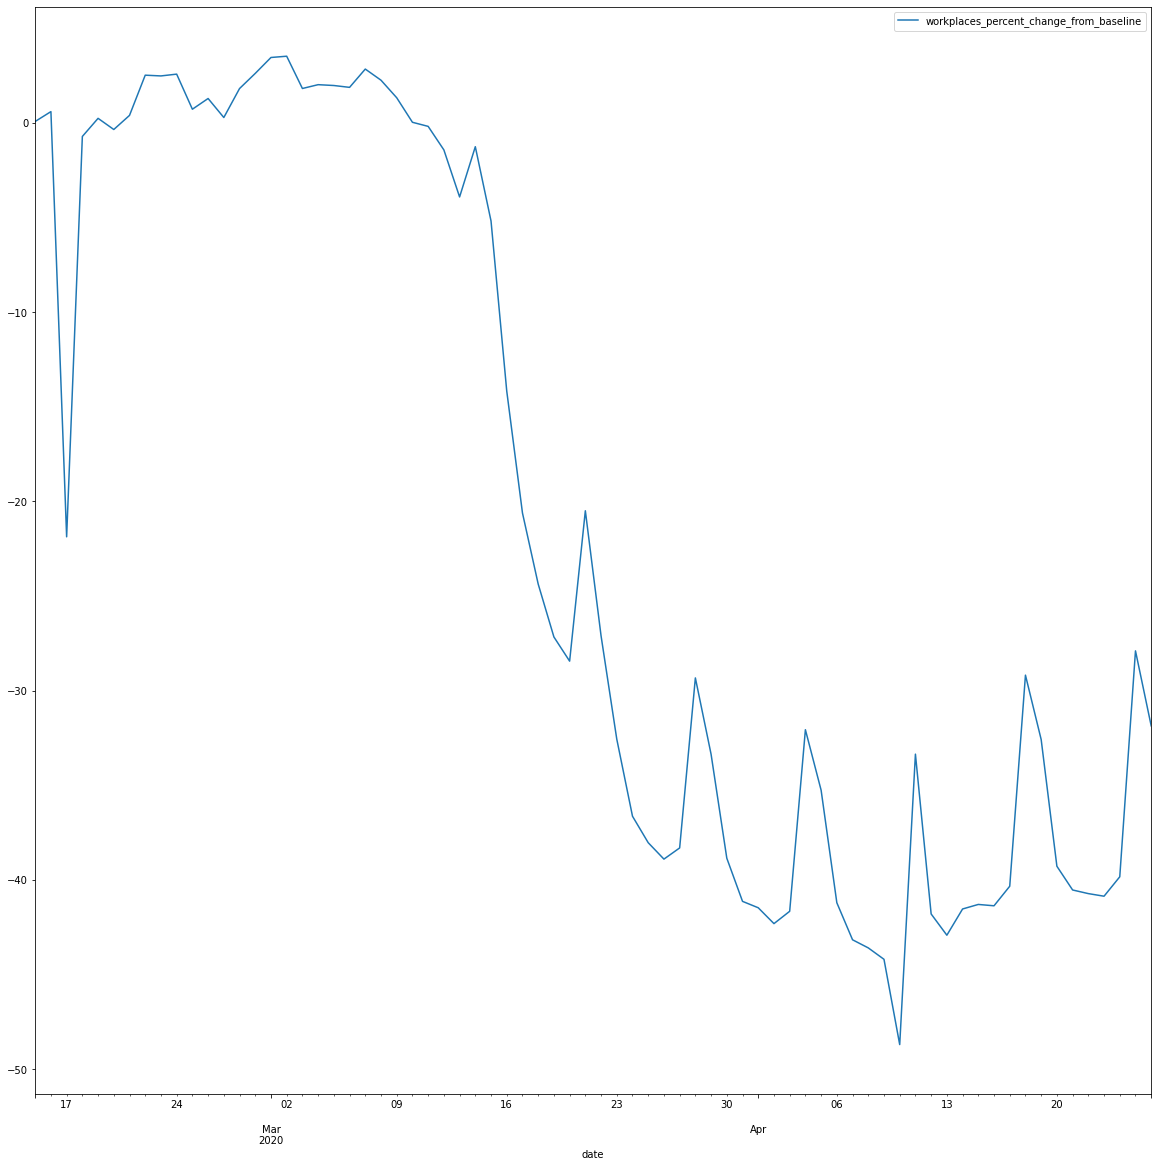

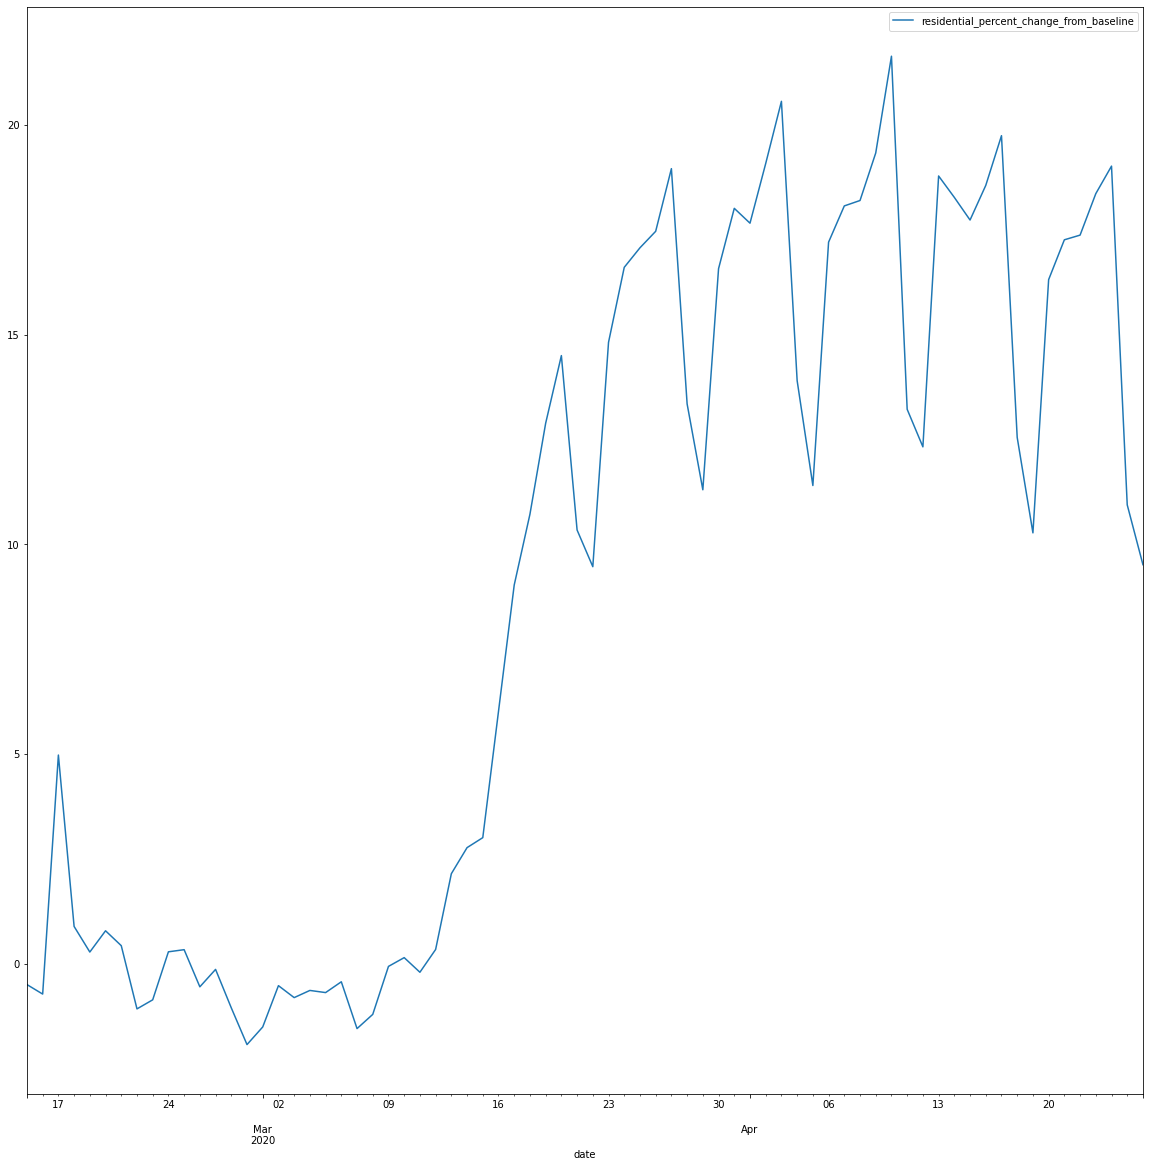

In [102]:
mobility_plot_us = mobility_plot_us(mobility_df, locations)

In [103]:
covid19_df.head()

,date,state,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,18,Alaska,0.0,0.0,0.0,0.0,0.0
1,18,Alabama,24.0,33.0,6570.0,177.0,6747.0
2,18,Arkansas,2.0,13.0,2867.0,63.0,2930.0
3,18,American Samoa,0.0,0.0,0.0,0.0,0.0
4,18,Arizona,16.0,38.0,2527.0,446.0,2973.0


In [104]:
mobility_df.head()

,state,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,Alabama,2020-02-15,5.155172,0.230769,49.571429,5.761905,0.784314,-0.863636
1,Alabama,2020-02-16,-1.454545,-4.015625,-5.476190,2.136364,-1.920000,0.523810
2,Alabama,2020-02-17,-1.169492,-4.476190,12.933333,5.727273,-16.264706,4.333333
3,Alabama,2020-02-18,-4.280702,-5.000000,-12.466667,-0.681818,0.338235,1.435897
4,Alabama,2020-02-19,1.438596,-0.730159,6.666667,3.714286,1.397059,0.000000


In [0]:
def get_week_mobility_and_covid19_data(mobility, covid19, state):
  mobility = mobility[mobility.state == state]
  mobility['date'] = pd.to_datetime(mobility['date'])
  mobility['date'] = mobility['date'].dt.weekofyear
  mobility = mobility.groupby(['date']).mean().reset_index()

  covid19 = covid19[covid19.state == state]
  covid19 = covid19.groupby(['date']).sum().reset_index()
  for col in list(covid19.columns)[2:]:
    covid19[col] = (covid19[col]-covid19[col].min())/(covid19[col].max()- covid19[col].min())*100 
  
  merged_data = pd.merge(mobility, covid19, on='date', how='inner')
  weeks_str = list()
  for w in np.sort(merged_data.date.unique()):
    s, e = week_of_year2dater(2020, int(w))
    weeks_str.append(str(s)+' - '+str(e))

  return merged_data, mobility, covid19, weeks_str

In [107]:
data = get_week_mobility_and_covid19_data(mobility_df, covid19_df, 'New York')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
data[0]['deathIncrease'] = (data[0]['deathIncrease'] - data[0]['deathIncrease'].min())/(data[0]['deathIncrease'].max()- data[0]['deathIncrease'].min())*100


In [0]:
outdoor_mean = data[0]
outdoor_mean['outdoor_mean'] = data[0][['grocery_and_pharmacy_percent_change_from_baseline', 'retail_and_recreation_percent_change_from_baseline','parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline']].mean(axis=1)

In [110]:
outdoor_mean.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,outdoor_mean
0,10,11.004608,7.486251,29.675596,6.052622,3.824885,-0.643423,0.000000,0.000000,0.000000,0.000000,0.000000,11.608792
1,11,5.131336,18.906625,36.150583,-4.005639,-0.403226,1.417620,0.057405,0.000000,3.092805,0.788715,2.628269,11.155936
2,12,-27.559908,11.527650,23.758407,-30.394375,-27.011521,12.089120,2.123995,12.324405,29.226904,21.543176,29.835014,-9.935950
3,13,-46.629032,-18.290323,-0.015848,-49.251077,-43.877880,19.095711,16.283965,63.064244,46.718412,66.471366,59.053994,-31.612832
4,14,-43.016129,-13.435484,12.485777,-50.897608,-45.923963,19.385903,61.117489,100.000000,47.271426,93.772910,69.158336,-28.157481


Text(0.5, 1.0, 'Community Mobility During COVID19 Outbreak')

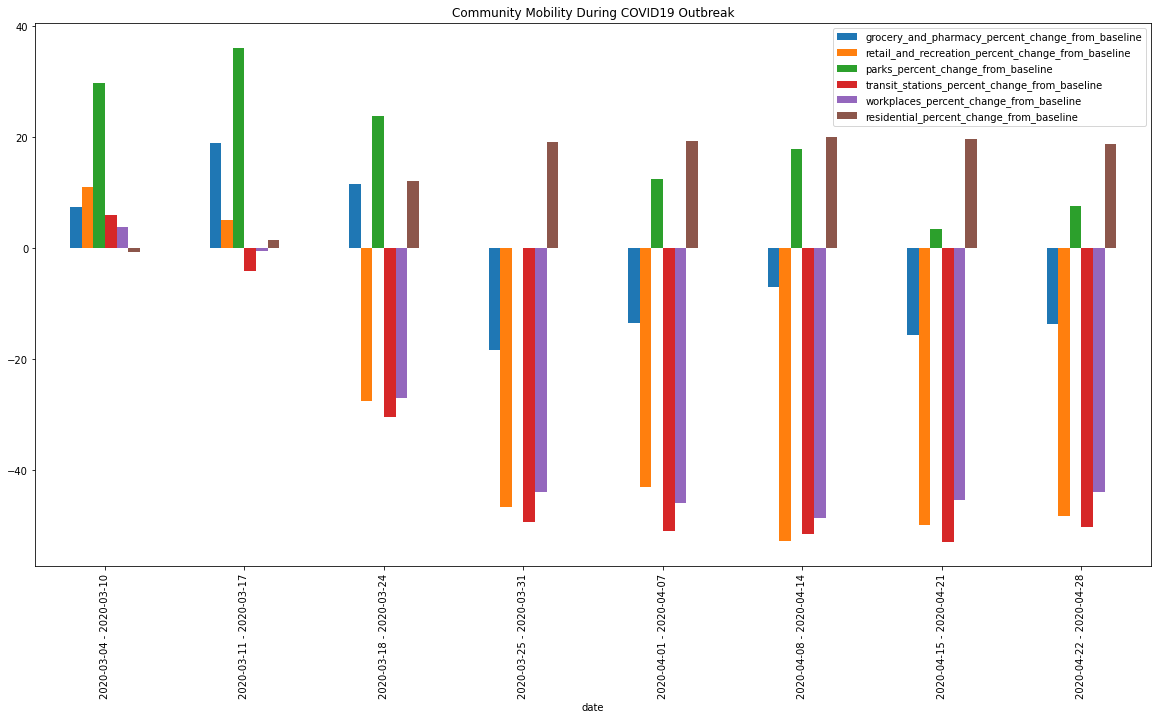

In [113]:
plot_1 = outdoor_mean.plot(x="date", y=['grocery_and_pharmacy_percent_change_from_baseline', 'retail_and_recreation_percent_change_from_baseline','parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline'], kind="bar",figsize=(20,10))
plot_1.set_xticklabels(data[3])
plt.title("Community Mobility During COVID19 Outbreak")